In [2]:
import glob
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import gaussian_kde

In [3]:
loaded_files = set()
file_label = {}
delta_over_hamming = {}       
delta_over_hamming_mean = {}
survival_rate = {}
time_for_food = {}
time_for_food_mean = {}

In [161]:
files = glob.glob('policy*.txt')
for file in {f for f in files if f not in loaded_files}:
    loaded_files.add(file)
    with open(file) as f:
        content = f.readlines()
    lines = [x.strip() for x in content]
    # Label
    file_label[file] = lines[0]
    delta_over_hamming[file] = dict((i, []) for i in range(1, 900)) # don't use 'set()' - arrays are close enough to mutlisets
    survival_rate[file] = dict((i, 0) for i in range(1, 900))
    time_for_food[file] = dict((i, []) for i in range(1, 900))
    # Times
    for line in lines[1:]:
        haming_dist_for_food = {}
        time_at_food = {}
        delta_for_food = {}
        split = line.strip().split()
        food = 1
        prevTime = 0
        for entry in split:
            survival_rate[file][food] += 1
            fragment = entry[1:-1].split(',')
            haming_dist_for_food[food] = int(fragment[0])
            time_at_food[food] = int(fragment[1])
            delta_for_food[food] = time_at_food[food] - prevTime
            
            time_for_food[file][food].append(time_at_food[food])
            delta_over_hamming[file][food].append(delta_for_food[food] - haming_dist_for_food[food])
            #print(delta_over_hamming[file][food])
            
            prevTime = time_at_food[food]
            food += 1
    delta_over_hamming_mean[file] = {}
    time_for_food_mean[file] = {}
    for food in range(1, 900):
        if len(delta_over_hamming[file][food]) < 10:
            break
        delta_over_hamming_mean[file][food] = mean(delta_over_hamming[file][food])
        time_for_food_mean[file][food] = mean(time_for_food[file][food])
    for food in reversed(range(1, 900)):
        survival_rate[file][food] /= survival_rate[file][1]
    

In [160]:
loaded_files.remove('policy14.txt')

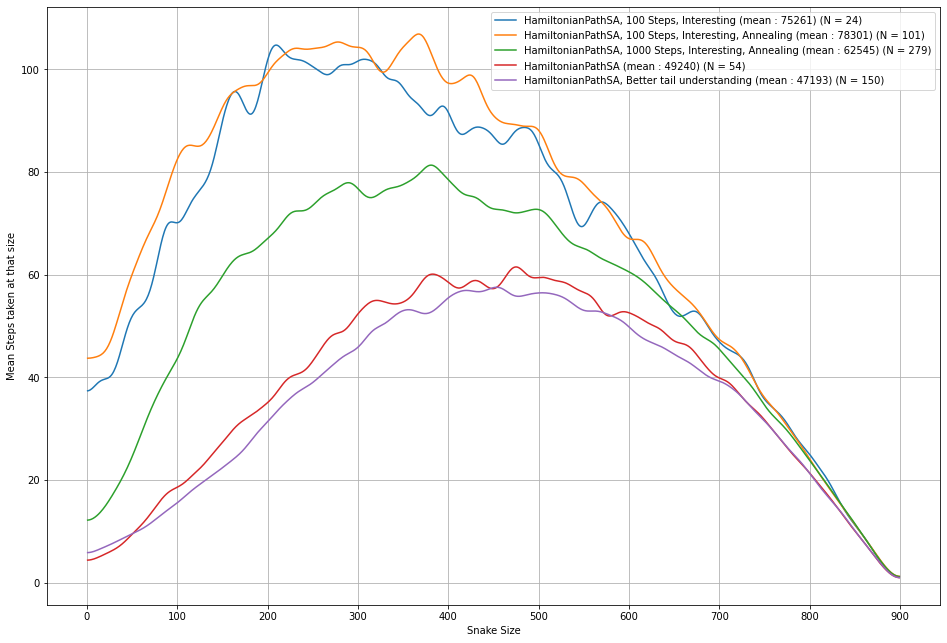

In [162]:
interesting_files = [
#    'policy6.txt',
    'policy7.txt',
    'policy8.txt',
    'policy10.txt',
    'policy13.txt',
    'policy14.txt'
]
for file in interesting_files:
    items = len(delta_over_hamming_mean[file])
    ysmoothed = gaussian_filter1d(list(delta_over_hamming_mean[file].values())[0:items], sigma=10)
    labl = file_label[file] + " (mean : "+str(round(np.mean(time_for_food[file][899]))) + ") (N = " + str(len(time_for_food[file][1])) + ")"
    plt.plot(np.linspace(1, items, items), ysmoothed, label = labl)
    #plt.plot(np.linspace(1, items, items), delta_over_hamming_mean[file].values(), label = labl)

plt.xlabel("Snake Size")
plt.ylabel("Mean Steps taken at that size")
plt.grid(axis = 'x')
plt.xticks(np.arange(0, 900+100, 100))
plt.grid(axis = 'y')
plt.legend()
plt.rcParams["figure.figsize"] = (16,11)

plt.show()

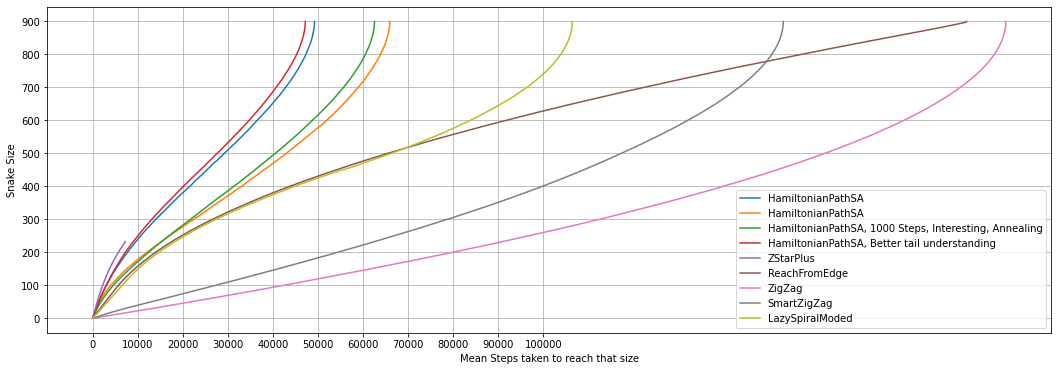

In [164]:
for file in files:
    items = len(time_for_food_mean[file])
    #ysmoothed = gaussian_filter1d(list(time_for_food_mean[file].values())[0:items], sigma=0.01)
    #plt.plot(np.linspace(1, items, items), ysmoothed, label = file_label[file])
    plt.plot(time_for_food_mean[file].values(), np.linspace(1, items, items), label = file_label[file])

plt.ylabel("Snake Size")
plt.xlabel("Mean Steps taken to reach that size")
plt.yticks(np.arange(0, 900+100, 100))
plt.xticks(np.arange(0, 100000+10000, 10000))
plt.legend()
plt.rcParams["figure.figsize"] = (18,6)
plt.grid(axis = 'x')
plt.grid(axis = 'y')

plt.show()

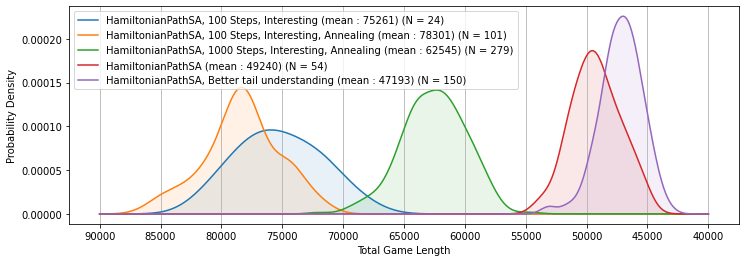

In [166]:
min_val = 40000
max_val = 90000
interesting_files = [
#    'policy6.txt',
    'policy7.txt',
    'policy8.txt',
    'policy10.txt',
    'policy13.txt',
    'policy14.txt'
]
xs = np.linspace(min_val, max_val,1000)
for file in interesting_files:
    density = gaussian_kde(time_for_food[file][899])
    
    #density.covariance_factor = lambda : 0.05
    #density._compute_covariance()
    
    labl = file_label[file] + " (mean : "+str(round(np.mean(time_for_food[file][899]))) + ") (N = " + str(len(time_for_food[file][1])) + ")"
    plt.plot(xs, density(xs), label = labl)
    plt.fill(xs, density(xs), alpha=0.1)
    
    #plt.plot(xs, means, label = "Policy "+str(i))
    #print(round(np.mean(time_for_food[file][899])))
    #plt.plot(xs,norm.pdf(xs, np.mean(data), np.std(data, ddof=1)))

plt.rcParams["figure.figsize"] = (12,4)
plt.ylabel("Probability Density")
plt.xlabel("Total Game Length")
plt.grid(axis = 'x')
plt.xticks(np.arange(40000, 90000+5000, 5000))
ax = plt.gca()
ax.invert_xaxis()
plt.legend()
plt.show()